#COMP9312_Project_Q2: Graph Convolutional Network 



You can edit this file and add the code to implement the model. 

For details about this project, please refer to the [project specification](https://cgi.cse.unsw.edu.au/~cs9312/22T2/dev/project/).

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

    └─Q2
        ├─1: Installing dependencies
        ├─2: Import the necessary package
        ├─3: Example of using Data in PyG
        ├─4: Download Real world dataset Cora
        ├─5: Output some basic attribute of the dataset **You code here**
        ├─6: Graph Convolutional Network By PyG **You code here**
        ├─7: Graph Convolutional Network By ourselves **You code here**
        ├─8: (optional) Another two message passing methods in PyG **You code here**

## Q2: Graph Neural Netwroks (10 points)

[PyG](PyTorch Geometric)(https://www.pyg.org/) is an extension library for PyTorch. It provides useful primitives to develop Graph Deep Learning models, including various graph neural network layers and a large number of benchmark datasets like

*   torch_geometric.nn
*   torch_geometric.data

*   torch_geometric.loader
*   torch_geometric.transforms

*   torch_geometric.utils

You might need to use a GPU for this Colab to run quickly.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.









### 1: Installing dependencies

The standard colab environment does not provide the package of PyG and its dependencies.
We need first to intsall it by the following commonds.

Note: This cell might take a while (up to ~10 minutes) to run

In [30]:
import torch
print("Torch has version {}".format(torch.__version__))

Torch has version 1.12.0+cu113


In [31]:
# Install torch geometric
# Change the version of the pytorch by modifying the url at the end
# For example, the output the above cell is 'Torch has version 1.11.0+cu113'，then the url is "***torch-1.11.0+cu113.html"
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
!pip install -q torch-geometric

### 2: Import the necessary package

In [32]:
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from scipy.linalg import fractional_matrix_power

### 3: Example of using **Data** in PyG

In tutorial 1 and Q1 of project, we use a class SimpleGraph and DirectedWeightedGraph to store the graph.
The pyg also provide a class called 'Data' to store the graph.

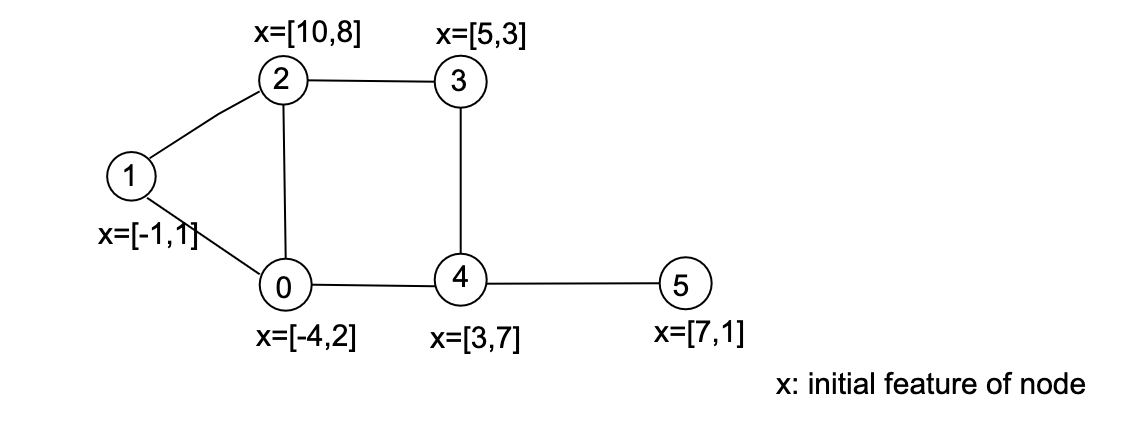

In [33]:
# The connection of edge
# for a undirected graph, use two directed edge to represent it. 
# edge_index is a tensor with shape of 2*edge_num 
edge_index = torch.tensor(
    [
        [0, 1, 0, 2, 1, 2, 2, 3, 4, 0, 4, 3, 5, 4],
        [1, 0, 2, 0, 2, 1, 3, 2, 0, 4, 3, 4, 4, 5],
    ],
    # the type of data
    dtype=torch.long
)

# the initial features of node
x = torch.tensor(
    [
        # there are 6 nodes
        # each node has a feature of length 2
        [-4, 2],
        [-1, 1],
        [10, 8],
        [5, 3],
        [3, 7],
        [7, 1],
    ]
)

# instantiate
data = Data(x=x, edge_index=edge_index)

# There may be other attribute of Data, like y which is the label of each node for 
# node classification

Now, we can print some infomation about the graph.

In [34]:
# the whole infomation about graph
print(data)

# the key in the graph
print(data.keys)
print(data.values)

# the feature of node
print(data['x'])
print(data.edge_index)
print(data.num_node_features)

Data(x=[6, 2], edge_index=[2, 14])
['x', 'edge_index']
<bound method BaseStorage.values of {'x': tensor([[-4,  2],
        [-1,  1],
        [10,  8],
        [ 5,  3],
        [ 3,  7],
        [ 7,  1]]), 'edge_index': tensor([[0, 1, 0, 2, 1, 2, 2, 3, 4, 0, 4, 3, 5, 4],
        [1, 0, 2, 0, 2, 1, 3, 2, 0, 4, 3, 4, 4, 5]])}>
tensor([[-4,  2],
        [-1,  1],
        [10,  8],
        [ 5,  3],
        [ 3,  7],
        [ 7,  1]])
tensor([[0, 1, 0, 2, 1, 2, 2, 3, 4, 0, 4, 3, 5, 4],
        [1, 0, 2, 0, 2, 1, 3, 2, 0, 4, 3, 4, 4, 5]])
2


### 4: Download Real world dataset Cora

Use a real world dataset 'Cora' which is often used for node classfication.
It contains one graph and the node in the graph belongs to 7 classes.

In [35]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

### 5: Output some basic attribute of the dataset (3 points)

In [36]:
# the number of graph in the dataset
############################################################################
# TODO: output the number of graph in Cora
# (~1 line of code)
############################################################################
print(len(dataset))

# the number of node of first graph in Cora
############################################################################
# TODO: output the number of node in the first graph of Cora
# (~1 line of code)
############################################################################
cora_first = dataset[0]
num_nodes = cora_first.num_nodes
print(num_nodes)

# the number of edges of first graph in Cora
############################################################################
# TODO: output the number of edges in the first graph of Cora
# (~1 line of code)
############################################################################
num_edges = cora_first.num_edges
print(num_edges)

# the dimension of feature
############################################################################
# TODO: output dimension of node feature in the first graph of Cora
# (~1 line of code)
############################################################################
feature_dim = cora_first.num_features
print(feature_dim)

# the number of classes
############################################################################
# TODO: output the number of classes that node of Cora belongs to.
# (~1 line of code)
############################################################################
num_classes = dataset.num_classes
print(num_classes)

# check if there are isolated nodes
############################################################################
# TODO: check if there are isolated nodes in the first graph of Cora.
# (~1 line of code)
############################################################################
isolated_node = cora_first.has_isolated_nodes()
print(isolated_node)

1
2708
10556
1433
7
False


### 6: Graph Convolutional Network By PyG (3 points)

Please follow the figure below to implement the `forward` function.

Here, we use a two layer GCN model. The GCN layer is implemented by `GCNConv` which is provided by PyG.

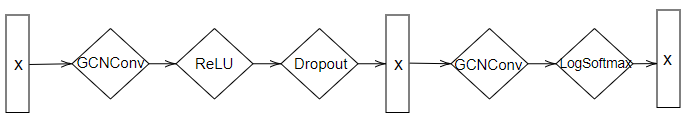

In [37]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        ############# Your code here ############
        ## Note:
        ## 1. Construct the network as shown in the figure
        ## 2. torch.nn.functional.relu and torch.nn.functional.dropout are useful
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/nn.functional.html
        ## 3. Don't forget to set F.dropout training to self.training
        ## (~5 lines of code)
        #########################################
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x)

        return x


In [38]:
# start train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(20):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [39]:
# start evaluate the model
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7240


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### 7: Graph Convolutional Networks By ourselves (4 points)

There are many variants of GCN formulation. Here, we use the matrix formulation of GCN as (https://openreview.net/pdf?id=SJU4ayYgl):

\begin{equation}
X^{k+1} = \sigma(\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}X^{k}\theta)
\end{equation}

here $\sigma$ is the non-linear function. X is the feature matrix. $\theta$ is the model parameters. $D\in R^{n*n}$ is the degree matrix. $I\in R^{n*n}$ is the identity matrix. $A\in R^{n*n}$ is the adjacent matrix. $\hat{D} = D+I$. And $\hat{A} = A+I$.


In [40]:
class Encoder(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels):
    super(Encoder, self).__init__()
    self.in_channels = in_channels
    self.hidden_channels = hidden_channels
    self.linear1 = torch.nn.Linear(in_channels, hidden_channels)
  
  def forward(self, x, edge_index):
    ############# Your code here ############
        ## Note:
        ## 1. Construct adjacnet matrix A of the graph
        ## 2. Calculte the degree matrix D
        ## 3: Calculte A_hat
        ## 4: Calculte the noramlized A_hat
        ## 5. multiply noramlized A_hat with x and theta
        ## np.diag, np.power, np.eye are useful
        ## (~11 lines of code)
    #########################################
    n_nodes = x.shape[0]
    A_hat = torch.zeros((n_nodes, n_nodes)) + torch.eye(n_nodes)
    for idx in range(len(edge_index)):
      row = edge_index[0][idx]
      col = edge_index[1][idx]
      A_hat[row][col] = 1
    D_hat = torch.zeros((n_nodes, n_nodes))
    for idx in range(n_nodes):
      D_hat[idx, idx] += sum(A_hat[idx, :]) + sum(A_hat[:, idx]) - 1
    normalized_D = fractional_matrix_power(D_hat, -1/2)
    normalized_D = torch.tensor(normalized_D)
    normalized_A = torch.matmul(normalized_D, A_hat)
    normalized_A = torch.matmul(normalized_A, normalized_D).to(device)
    x = torch.matmul(normalized_A, x)
    theta = torch.transpose(self.linear1.weight, 0, 1)
    x = torch.matmul(x, theta)
    return x


In [41]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = Encoder(in_channels, 16)
        self.conv2 = Encoder(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # !!! notice here
        # move your code in part 6 here.
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x)
        return x
# start train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(20):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
# start evaluate the model
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

--------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
--------------
Accuracy: 0.3700


### 8: (Optional) Use another two methods of the message passing layer in the above GNN model.(2 points)
We've defined a GNN class that uses GCNConvolutional layers, suggest and test th accuracy of two other variations of this GNN class that 
uses a different message passing mechanism by replacing the above GCNConv layer.

You can use the function provided by PyG or implemented by yourself. 

Include a **short description** about the message pass layer you choose and their **accuracy**. You can write them in an seperated report or you can directly edit here.

Up to 2 points for this optional question and up to 10 points for the whole Q2.